In [1]:
import os
import torch
import probtorch
from utils.file_handling import load_nparray
from models.architectures.encoders.fc import HFVAEFCEncoder
from models.architectures.decoders.fc import HFVAEFCDecoder
from models.hfvae import HFVAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import time
import numpy as np

os.chdir('..')
print(os.getcwd())
# model parameters

INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50

# training parameters
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 5e-5
BETA1 = 0.99
EPS = 1e-9
CUDA = torch.cuda.is_available()

# saving
SAVE_PATH = 'results/hfvae'


/home/dorian/FER/master_thesis/src/base


In [2]:
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open('resources/datasets/20_newsgroups/json/topics.json', 'r'))
train_data = load_nparray('resources/datasets/20_newsgroups/preprocessed/train_bow.txt')
train_labels = np.loadtxt('resources/datasets/20_newsgroups/preprocessed/train_labels.txt')
test_data = load_nparray('resources/datasets/20_newsgroups/preprocessed/test_bow.txt')
test_labels = np.loadtxt('resources/datasets/20_newsgroups/preprocessed/test_labels.txt')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, train_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

enc = HFVAEFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = HFVAEFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = HFVAE(encoder=enc, decoder=dec)
model.cuda()
model.double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, probtorch=True, included_labels=True).run(optimizer, NUM_EPOCHS)


In [7]:
# EVALUATION
# model loading
enc = HFVAEFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = HFVAEFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = HFVAE(encoder=enc, decoder=dec)
model.load_state_dict(torch.load('results/hfvae/model.pt'))
model.cuda()
model.double()
model.eval()

HFVAE(
  (encoder): HFVAEFCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): HFVAEFCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

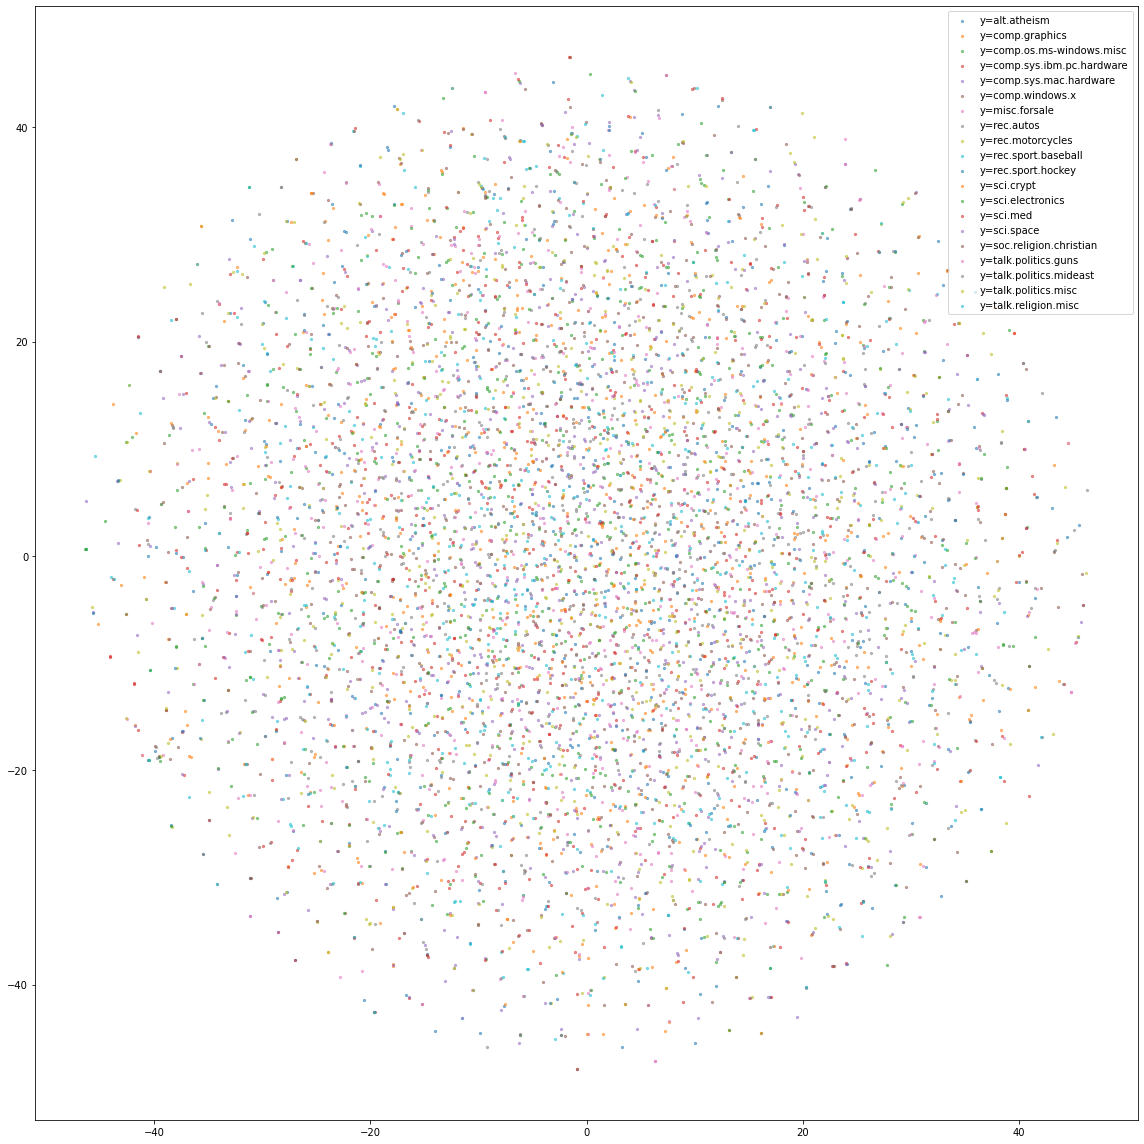

In [10]:
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
zs = []
ys = []
for (x, y) in test_loader:
    if len(x) == BATCH_SIZE:
        q = model.encode(x.cuda())
        z = q['z'].value.cpu().detach().numpy()
        zs.append(z.reshape(-1, LATENT_DIM))
        ys.append(y.numpy())

zs = np.concatenate(zs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
zs2 = TSNE().fit_transform(zs)

fig = plt.figure(figsize=(16,16))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k], alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()


In [ ]:
# mutual information
from probtorch.objectives.marginal import kl
from sklearn.feature_selection import mutual_info_regression

MI = [mutual_info_regression(X=test_data, y=zs[:,i], discrete_features=True) for i in range(LATENT_DIM)]
# TODO - come back to this
print(MI)



In [ ]:
# topic coherence score
from gensim.models.coherencemodel import CoherenceModel





In [ ]:
# BACKUP TRAINER
# train_loader = torch.utils.data.DataLoader(load_nparray('resources/datasets/20_newsgroups/preprocessed/train_bow.txt'),
#                                          batch_size=BATCH_SIZE, shuffle=True)
# test_loader = torch.utils.data.DataLoader(load_nparray('resources/datasets/20_newsgroups/preprocessed/test_bow.txt'),
#                                         batch_size=BATCH_SIZE, shuffle=True)
#
#
# enc = HFVAEFCEncoder(input_dim=2000, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
# dec = HFVAEFCDecoder(latent_dim=LATENT_DIM, output_dim=2000)
# model = HFVAE(encoder=enc, decoder=dec)
# model.cuda()
# model.double()
# optimizer =  torch.optim.Adam(list(model.parameters()), lr=LEARNING_RATE, betas=(BETA1, 0.999))
#
# def train(data, model, optimizer):
#     epoch_elbo = 0.0
#     model.train()
#     N = 0
#     for b, texts in enumerate(data):
#         if texts.size()[0] == BATCH_SIZE:
#             N += BATCH_SIZE
#             if CUDA:
#                 texts = texts.cuda()
#             optimizer.zero_grad()
#             q, p = model(texts)
#             loss = model.loss_function(q, p)
#             loss.backward()
#             optimizer.step()
#             if CUDA:
#                 loss = loss.cpu()
#             epoch_elbo -= float(loss.item())
#     return epoch_elbo / N
#
# def test(data, model):
#     model.eval()
#     epoch_elbo = 0.0
#     N = 0
#     for b, texts in enumerate(data):
#         if texts.size()[0] == BATCH_SIZE:
#             N += BATCH_SIZE
#             if CUDA:
#                 texts = texts.cuda()
#             q, p = model.forward(texts)
#             batch_elbo = -model.loss_function(q, p)
#             if CUDA:
#                 batch_elbo = batch_elbo.cpu()
#             epoch_elbo += float(batch_elbo.item())
#     return epoch_elbo / N
#
# for e in range(NUM_EPOCHS):
#     train_start = time.time()
#     train_elbo = train(train_loader, model, optimizer)
#     train_end = time.time()
#     test_start = time.time()
#     test_elbo = test(test_loader, model)
#     test_end = time.time()
#     print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e (%ds)' % (
#             e, train_elbo, train_end - train_start,
#             test_elbo, test_end - test_start))